In [3]:
import keras
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,model_from_json
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline
from decimal import Decimal
import warnings
warnings.filterwarnings("ignore")
import pickle
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import Normalizer, MinMaxScaler
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.


In [4]:
df=pd.read_csv('C:\\Users\\lengada1\\NCSU\\DC_ten_skus.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.weekday_name
day_dummy=pd.get_dummies(df.Day)
df=pd.concat([df,day_dummy],axis=1)
df.drop(['Day','Date'],inplace=True,axis=1)

y=df['Sales']


In [5]:
df.head()
df.shape

(942, 16)

In [6]:
X=df.drop(['id','DayOfWeek','Customers','Sales'],inplace=False,axis=1)
X.head()

,Open,Promo,SchoolHoliday,Year,Month,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,10,2013,1,0,0,0,0,0,1,0
1,10,0,10,2013,1,0,0,0,0,0,0,1
2,10,0,8,2013,1,0,0,0,0,1,0,0
3,10,0,8,2013,1,1,0,0,0,0,0,0
4,10,0,1,2013,1,0,0,1,0,0,0,0


In [7]:
for obs in range(1,8):
    X["Sales_T"+str(obs)]=df['Sales'].shift(obs)
X.head()

,Open,Promo,SchoolHoliday,Year,Month,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Sales_T1,Sales_T2,Sales_T3,Sales_T4,Sales_T5,Sales_T6,Sales_T7
0,0,0,10,2013,1,0,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,0,10,2013,1,0,0,0,0,0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,10,0,8,2013,1,0,0,0,0,1,0,0,60436.0,0.0,NaN,NaN,NaN,NaN,NaN
3,10,0,8,2013,1,1,0,0,0,0,0,0,52848.0,60436.0,0.0,NaN,NaN,NaN,NaN
4,10,0,1,2013,1,0,0,1,0,0,0,0,55606.0,52848.0,60436.0,0.0,NaN,NaN,NaN


In [8]:
X['Mov_avg']=pd.rolling_mean(df['Sales'], window=7).shift(1) 
y=y[7:]
X=X[7:]
y.reset_index(drop=True, inplace=True)
X.reset_index(drop=True, inplace=True)
X.head()
X.shape

(935, 20)

In [9]:
train_size=800
X_train, X_test, y_train, y_test =  X[0:train_size], X[train_size:len(X)], y[0:train_size], y[train_size:len(X)]

In [10]:
def RF_model(X_train, X_test, y_train, y_test):
    tree=RandomForestRegressor( random_state=2)
    tree.fit(X_train,y_train)
    pred=tree.predict(X_test)
    pred=pd.DataFrame(pred)
    pred.reset_index(drop=True, inplace=True)
    pred=pred.rename(columns = {0:'RF'})
    return pred

def NN_model(X_train, X_test, y_train, y_test):
    model = Sequential()
    model.add(Dense(20, input_dim=X_train.shape[1], activation='linear'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(40, activation='linear'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae','mse'])
    model.fit(X_train, y_train, epochs=800, batch_size=10, verbose=0)
    prediction=model.predict(X_test, verbose=0)
    pred=pd.DataFrame(prediction)
    pred.reset_index(drop=True, inplace=True)
    pred=pred.rename(columns = {0:'NN'})
    return pred

def GB_model(X_train, X_test, y_train, y_test):
    params = {'n_estimators': 500, 'max_depth': 40, 'min_samples_split': 20,
          'learning_rate': 0.01, 'loss': 'ls'}
    model = ensemble.GradientBoostingRegressor(**params)
    model.fit(X_train, y_train)
    prediction=model.predict(X_test)
    pred=pd.DataFrame(prediction)
    pred.reset_index(drop=True, inplace=True)
    pred=pred.rename(columns = {0:'GB'})
    return pred

In [16]:
RF_pred=RF_model(X_train, X_test, y_train, y_test);
NN_pred=NN_model(X_train, X_test, y_train, y_test);
GB_pred=GB_model(X_train, X_test, y_train, y_test);

In [24]:
def MAE_score(y_true,pred1, pred2,pred3):
    mae1 = mean_absolute_error(y_true, pred1)
    mae2 = mean_absolute_error(y_true, pred2)
    mae3 = mean_absolute_error(y_true, pred3)
    return  [mae1.round(),mae2.round(),mae3.round()] 

In [104]:
mae=MAE_score(y_test,RF_pred,NN_pred,GB_pred)
mae=pd.DataFrame(np.array(mae).reshape(1,3), columns = ["RB", "NN", "GB"])
best=mae.idxmin(axis=1)
best.astype('category')
mae["Best"]=best
mae

,RB,NN,GB,Best
0,3137.0,7478.0,3094.0,GB


In [105]:
bm_dict={}
for sku in range(0,1):
        
        if  mae["Best"][0]=="RF":
            tree=RandomForestRegressor( random_state=2)
            tree.fit(X,y)
            pred=tree.predict(X)
            pred=pd.DataFrame(pred)
            pred.reset_index(drop=True, inplace=True)
            pred=pred.rename(columns = {0:'RF'})
            bm_dict[sku]=pred
            
        
        elif mae["Best"][0]=="NN":
            model = Sequential()
            model.add(Dense(20, input_dim=X_train.shape[1], activation='linear'))
            model.add(Dense(20, activation='relu'))
            model.add(Dense(40, activation='linear'))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(1, activation='linear'))
            model.compile(loss='mse', optimizer='adam', metrics=['mae','mse'])
            model.fit(X, y, epochs=1, batch_size=10, verbose=0)
            prediction=model.predict(X, verbose=0)
            pred=pd.DataFrame(prediction)
            pred.reset_index(drop=True, inplace=True)
            pred=pred.rename(columns = {0:'NN'})
            bm_dict[sku]=pred
                    
            
        elif mae["Best"][0]=="GB":
            params = {'n_estimators': 500, 'max_depth': 40, 'min_samples_split': 20,
          'learning_rate': 0.01, 'loss': 'ls'}
            model = ensemble.GradientBoostingRegressor(**params)
            model.fit(X, y)
            prediction=model.predict(X)
            pred=pd.DataFrame(prediction)
            pred.reset_index(drop=True, inplace=True)
            pred=pred.rename(columns = {0:'GB'})
            bm_dict[sku]=pred  


In [108]:
dc_pred=pd.DataFrame(bm_dict[0])
sku_pred=pd.read_csv('C:\\Users\\lengada1\\NCSU\\prediction_skus.csv')
sku_pred=sku_pred.iloc[:,1:]
X2=pd.concat([sku_pred,dc_pred],axis=1)
X2.head()

,1,2,3,4,5,6,7,8,9,10,Total,GB
0,5684.4,6190.1,9859.894340,10490.9,5665.098160,7145.6,9954.2,6292.539174,6125.8,5568.9,72977.431674,71820.234087
1,5373.7,6552.9,8033.101024,8907.5,5884.144706,6759.3,7349.8,5150.737436,4850.8,5609.5,64471.483167,64197.798650
2,4946.9,5559.8,7741.635302,9499.8,4962.824895,6151.7,7831.3,6155.145186,5485.4,5717.3,64051.805383,63663.613568
3,4792.4,4884.3,9185.959569,10425.7,5135.382855,6766.3,7554.1,5000.858661,5748.6,5715.9,65209.501085,64958.456621
4,4920.9,2540.7,4440.899831,9821.4,1779.007038,3904.0,4698.0,2639.417860,4434.3,4469.3,43647.924730,43276.067152


In [109]:
train_size=800
X2_train, X2_test, y2_train, y2_test =  XX[0:train_size], XX[train_size:len(X)], y[0:train_size], y[train_size:len(X)]

In [110]:
RF2_pred=RF_model(X2_train, X2_test, y2_train, y2_test);
NN2_pred=NN_model(X2_train, X2_test, y2_train, y2_test);
GB2_pred=GB_model(X2_train, X2_test, y2_train, y2_test);

In [111]:
mae2=MAE_score(y2_test,RF2_pred,NN2_pred,GB2_pred)
mae2=pd.DataFrame(np.array(mae2).reshape(1,3), columns = ["RB", "NN", "GB"])
best2=mae2.idxmin(axis=1)
best2.astype('category')
mae2["Best"]=best
mae2

,RB,NN,GB,Best
0,411.0,347.0,502.0,GB


In [121]:
bm2_dict={}
for sku in range(0,1):
        
        if  mae2["Best"][0]=="RF":
            tree=RandomForestRegressor( random_state=2)
            tree.fit(X2,y)
            pred=tree.predict(X2)
            pred=pd.DataFrame(pred)
            pred.reset_index(drop=True, inplace=True)
            pred=pred.rename(columns = {0:'RF2'})
            bm2_dict[sku]=pred
            
        
        elif mae2["Best"][0]=="NN":
            model = Sequential()
            model.add(Dense(20, input_dim=X2_train.shape[1], activation='linear'))
            model.add(Dense(20, activation='relu'))
            model.add(Dense(40, activation='linear'))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(1, activation='linear'))
            model.compile(loss='mse', optimizer='adam', metrics=['mae','mse'])
            model.fit(X2, y, epochs=1, batch_size=10, verbose=0)
            prediction=model.predict(X, verbose=0)
            pred=pd.DataFrame(prediction)
            pred.reset_index(drop=True, inplace=True)
            pred=pred.rename(columns = {0:'NN2'})
            bm2_dict[sku]=pred
                    
            
        elif mae2["Best"][0]=="GB":
            params = {'n_estimators': 500, 'max_depth': 40, 'min_samples_split': 20,
          'learning_rate': 0.01, 'loss': 'ls'}
            model = ensemble.GradientBoostingRegressor(**params)
            model.fit(X2, y)
            prediction=model.predict(X2)
            pred=pd.DataFrame(prediction)
            pred.reset_index(drop=True, inplace=True)
            pred=pred.rename(columns = {0:'GB2'})
            bm2_dict[sku]=pred  
   

In [127]:
tier_pred=pd.concat([bm_dict[0],bm2_dict[0],y],axis=1)
tier_pred.columns = ['DC_Tier1', 'DC_Tier2',"Sales"]
tier_pred.to_csv('C:\\Users\\lengada1\\NCSU\\DC_tier_predictions.csv')
tier_pred.head()

,DC_Tier1,DC_Tier2,Sales
0,71820.234087,72409.705874,72552
1,64197.798650,64188.607022,64297
2,63663.613568,63884.418904,64112
3,64958.456621,64943.011251,65006
4,43276.067152,43270.483161,43300


In [10]:
# serialize model to JSON
# also look at joblib.  https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
model_json = model.to_json()
with open("NCSU_DC.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NCSU_DC.h5")
print("Saved model to disk")

Saved model to disk


In [12]:
# load json and create model
json_file = open('NCSU_DC.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("NCSU_DC.h5")
print("Loaded model from disk")

Loaded model from disk


In [32]:
# evaluate loaded model on test data
loaded_model.compile(loss='mse', optimizer='adam', metrics=['mae','mse'])
score = loaded_model.evaluate(Xs, y, verbose=0)
print("%s: %.0f"%  (loaded_model.metrics_names[1], score[1]))
print("%s: %.1f"%  (loaded_model.metrics_names[2], score[2]/10000000))

mean_absolute_error: 3687
mean_squared_error: 2.9


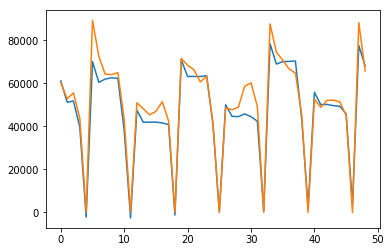

In [437]:
pred2=pd.DataFrame(prediction2)
pred3=pd.concat([pred2,y],axis=1)
#pred3.head()

plt.plot(pred3.iloc[:50,0]   ) 
plt.plot(pred3.iloc[:50,1]   )

#plt.show()